In [1]:
import sys
from pathlib import Path

exp_dir = str(Path("..").resolve())
if exp_dir not in sys.path:
    sys.path.insert(0, exp_dir)

(1000,)


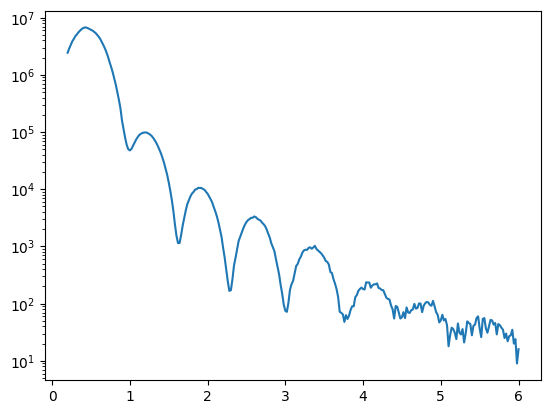

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from reflecto.io_utils import load_xrr_dat
from reflecto.physics_utils import tth2q
from reflecto.simulate.simul_genx import ParamSet, param2refl

data_file = Path(r"D:\03_Resources\Data\XRR_AI\XRR_data\XRR_data2\#1.dat")
weights_path = Path(r"D:\03_Resources\Data\XRR_AI\data\one_layer") / "power1_tune"
qs_file = weights_path / "qs.npy"
qs = np.load(qs_file)
print(qs.shape)
tths, R_raw = load_xrr_dat(data_file)
q_raw = tth2q(tths)
plt.plot(tths, R_raw)
plt.yscale("log")

[Inference] Device: cuda
[Inference] Loaded training config from D:\03_Resources\Data\XRR_AI\data\one_layer\power1_tune\config.json
[Inference] Grid Generation: Power=1, Points=1000
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\power1_tune\best.pt
>>> NN Prediction:
Thickness : 132.79 Å
Roughness : 1.75 Å
SLD : 18.710 (10⁻⁶ Å⁻²)


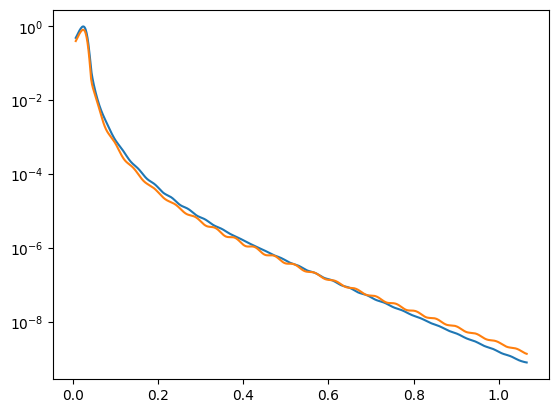

In [6]:
from fitting_engine import GenXFitter
from inference import XRRInferenceEngine
from reflecto.math_utils import powerspace

powerq = powerspace(tth2q(0.1), tth2q(15), 1000, 1)
param = ParamSet(150, 2, 20)
sim_refl = param2refl(powerq, [param])

inference_engine = XRRInferenceEngine(exp_dir=weights_path)

pred_d, pred_sig, pred_sld = inference_engine.predict(powerq, sim_refl)


print(">>> NN Prediction:")
print(f"Thickness : {pred_d:.2f} Å")
print(f"Roughness : {pred_sig:.2f} Å")
print(f"SLD : {pred_sld:.3f} (10⁻⁶ Å⁻²)")

param = ParamSet(pred_d, pred_sig, pred_sld)
new_sim_refl = param2refl(powerq, [param])

plt.plot(powerq, sim_refl / sim_refl.max())
plt.plot(powerq, new_sim_refl)
plt.yscale("log")

[Inference] Device: cuda
[Inference] Loaded training config from D:\03_Resources\Data\XRR_AI\data\one_layer\power1_tune\config.json
[Inference] Grid Generation: Power=1, Points=1000
[Inference] Model loaded from D:\03_Resources\Data\XRR_AI\data\one_layer\power1_tune\best.pt
>>> NN Prediction:
Thickness : 134.05 Å
Roughness : 1.67 Å
SLD : 8.529 (10⁻⁶ Å⁻²)


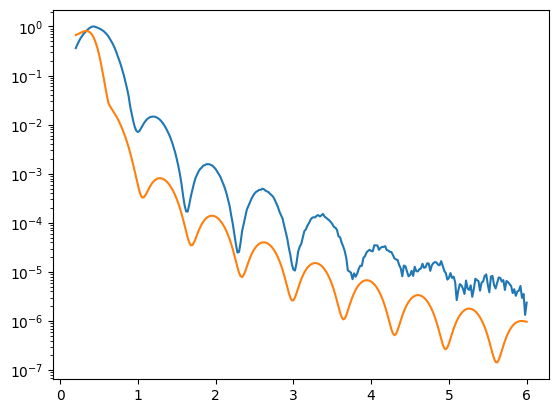

In [7]:
inference_engine = XRRInferenceEngine(exp_dir=weights_path)

pred_d, pred_sig, pred_sld = inference_engine.predict(q_raw, R_raw)


print(">>> NN Prediction:")
print(f"Thickness : {pred_d:.2f} Å")
print(f"Roughness : {pred_sig:.2f} Å")
print(f"SLD : {pred_sld:.3f} (10⁻⁶ Å⁻²)")

param = ParamSet(pred_d, pred_sig, pred_sld)
sim_refl = param2refl(q_raw, [param])

plt.plot(tths, R_raw / R_raw.max())
plt.plot(tths, sim_refl)
plt.yscale("log")


[GenX] Step 1: Fitting I0 & Sample Length...
  -> I0: 1.562, Sample Len: 2.00 mm
[GenX] Step 2: Fitting All Params (Log)...

----------------------------------------
FINAL ANALYSIS RESULT
----------------------------------------
set_f_d        : 96.1485
set_f_sig      : 12.5257
set_f_sld      : 39.4709
set_s_d        : 23.0080
set_s_sig      : 5.7184
set_s_sld      : 23.0000
set_i0         : 5.0000
set_s_len      : 12.0396


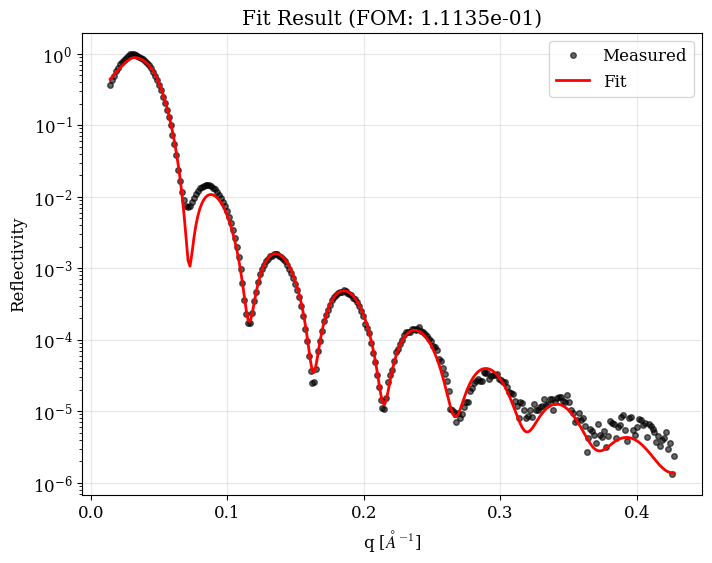

nn_preds: (np.float32(134.0496), np.float32(1.6676207), np.float32(8.529489))
final_params: {'set_f_d': 96.14851233909697, 'set_f_sig': 12.525696068636735, 'set_f_sld': 39.47093007691397, 'set_s_d': 23.008007830125194, 'set_s_sig': 5.718416775220161, 'set_s_sld': 22.99999999974235, 'set_i0': 4.999999998313243, 'set_s_len': 12.039593316500387}
fitter: <fitting_engine.GenXFitter object at 0x0000022A3248F530>


In [47]:
nn_initial_params = ParamSet(pred_d, pred_sig, pred_sld)
# nn_initial_params = ParamSet(119, 1, 39)
fitter = GenXFitter(q_raw, R_raw, nn_initial_params)

# 피팅 실행
final_results = fitter.run(verbose=True)
    # ---------------------------------------------------------

print("\n" + "-"*40)
print("FINAL ANALYSIS RESULT")
print("-"*40)
for param_name, value in final_results.items():
    print(f"{param_name:15s}: {value:.4f}")
print("="*40)


fitter.plot()

# 결과 반환
result = {
"nn_preds": (pred_d, pred_sig, pred_sld),
"final_params": final_results,
"fitter": fitter,
}

for key, val in result.items():
    print(f"{key}: {val}")

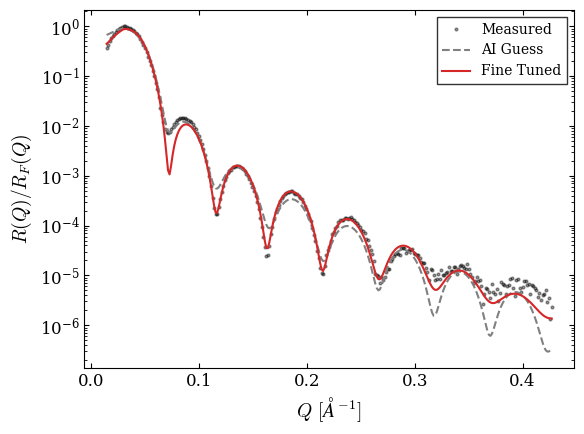

In [48]:
param = ParamSet(120, 4, 41)
sim_refl = param2refl(q_raw, [param])
import matplotlib.pyplot as plt

# 1. LaTeX 스타일 폰트 설정 (Times New Roman 느낌)
plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'cm', # Computer Modern (TeX 폰트)
    'font.size': 12,
})

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

# 2. 플롯 그리기
# 측정 데이터: 작고 진한 점
ax.plot(q_raw, R_raw / R_raw.max(), 'k.',
        markersize=4,
        alpha=0.4,
        label="Measured")

# AI 초기값: 회색 혹은 옅은 색 점선
ax.plot(q_raw, sim_refl, linestyle='--',
        color='gray',
        linewidth=1.5,
        label="AI Guess")

# 파인 튜닝: 진한 빨강 실선
ax.plot(q_raw, fitter.R_sim, linestyle='-',
        color='#D62728', # Matplotlib 기본 빨강보다 약간 고급진 색
        linewidth=1.5,
        label="Fine Tuned")

# 3. 축 설정
ax.set_yscale("log")
ax.set_xlabel(r"$Q \ [\AA^{-1}]$", fontsize=14)
ax.set_ylabel(r"$R(Q)/R_F(Q)$", fontsize=14) # 혹은 단순히 Reflectivity

# 4. 틱(Tick) 설정 - 사방으로 눈금 표시 (Box style)
ax.tick_params(direction='in', which='both', top=True, right=True)

# 5. 범례
ax.legend(frameon=True, fancybox=False, edgecolor='black', fontsize=10)

plt.tight_layout()
plt.show()

In [49]:
# from inference_pipeline import run_xrr_analysis

# data_root = Path(r"D:\03_Resources\Data\XRR_AI\XRR_data\XRR_data")
# weights_path = Path(r"D:\03_Resources\Data\XRR_AI\data\one_layer\sio2_random2")
# inference_engine = XRRInferenceEngine(exp_dir=weights_path)

# for dat_file in data_root.glob("*.dat"):
#     print(dat_file.name)
#     run_xrr_analysis(dat_file, weights_path, inference_engine, verbose=False, show_plot=True)

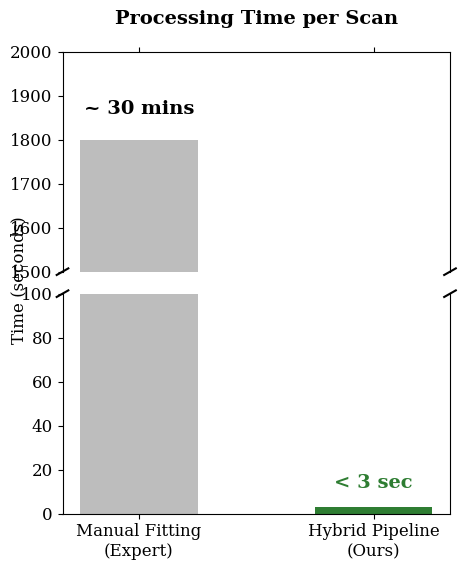

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 가상의 대표 데이터 (단위: 초)
# Manual: 평균 30분 (1800초) ~ 60분 범위
# Hybrid: 평균 2초 ~ 4초 범위
means = [1800, 3]
labels = ['Manual Fitting\n(Expert)', 'Hybrid Pipeline\n(Ours)']
colors = ['#bdbdbd', '#2e7d32'] # 회색 vs 초록색

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 6))
fig.subplots_adjust(hspace=0.1)  # 위아래 그래프 간격 조절

# 같은 데이터를 두 축에 나눠서 그림
ax1.bar(labels, means, color=colors, width=0.5)
ax2.bar(labels, means, color=colors, width=0.5)

# 축 범위 설정 (Broken Axis 효과)
ax1.set_ylim(1500, 2000)  # 위쪽 그래프: 1500~2000초 구간
ax2.set_ylim(0, 100)      # 아래쪽 그래프: 0~100초 구간

# 위쪽 그래프의 X축 눈금 제거
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # 위쪽 라벨 제거
ax2.xaxis.tick_bottom()

# 빗금(Diagonal lines)으로 잘린 부분 표현
d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# 텍스트 라벨 추가 (가장 중요!)
ax1.text(0, 1850, "~ 30 mins", ha='center', va='bottom', fontsize=14, fontweight='bold')
ax2.text(1, 10, "< 3 sec", ha='center', va='bottom', fontsize=14, fontweight='bold', color='#2e7d32')

# 제목 및 Y축 라벨
ax1.set_title("Processing Time per Scan", fontsize=14, fontweight='bold', pad=20)
fig.text(0.02, 0.5, 'Time (seconds)', va='center', rotation='vertical', fontsize=12)

plt.show()

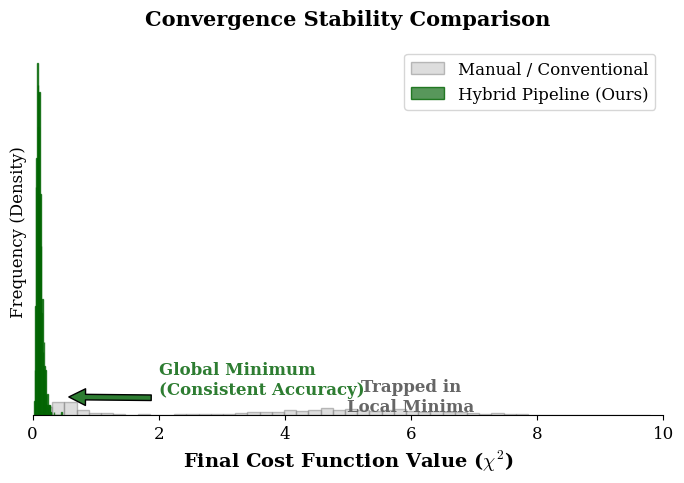

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 생성 (가상의 대표값)
np.random.seed(42)
n_samples = 1000

# 1. Hybrid Pipeline (Ours): 에러가 0에 가깝게 수렴 (성공률 100%)
hybrid_errors = np.random.lognormal(mean=np.log(0.1), sigma=0.4, size=n_samples)

# 2. Manual / Conventional: 에러가 들쭉날쭉함 (Local Minima에 빠짐)
# 잘 된 경우(30%)와 망한 경우(70%)를 섞어서 현실적으로 표현
manual_good = np.random.lognormal(mean=np.log(0.5), sigma=0.5, size=int(n_samples * 0.3))
manual_bad = np.random.normal(loc=5.0, scale=1.5, size=int(n_samples * 0.7))
manual_errors = np.concatenate([manual_good, manual_bad])
manual_errors = manual_errors[manual_errors > 0] # 음수 제거

# 그래프 그리기
plt.figure(figsize=(7, 5)) # 포스터 공간에 맞춰 비율 조정

# 히스토그램 그리기
plt.hist(manual_errors, bins=50, alpha=0.5, color='#bdbdbd', label='Manual / Conventional', density=True, edgecolor='grey')
plt.hist(hybrid_errors, bins=50, alpha=0.8, color='#2e7d32', label='Hybrid Pipeline (Ours)', density=True, edgecolor='darkgreen')

# 라벨 및 스타일 설정
plt.xlabel(r'Final Cost Function Value ($\chi^2$)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency (Density)', fontsize=12)
plt.title('Convergence Stability Comparison', fontsize=15, fontweight='bold', pad=15)

# 화살표 및 텍스트 주석 (Highlight)
plt.annotate('Global Minimum\n(Consistent Accuracy)', xy=(0.5, 0.6), xytext=(2, 0.7),
             arrowprops=dict(facecolor='#2e7d32', shrink=0.05),
             fontsize=12, fontweight='bold', color='#2e7d32')

plt.text(6, 0.15, 'Trapped in\nLocal Minima', fontsize=12, fontweight='bold', color='#666666', ha='center')

plt.legend(fontsize=12)
plt.xlim(0, 10) # 핵심 영역만 보여주기 위해 X축 제한
plt.yticks([])  # Y축 숫자는 중요하지 않으므로 제거 (깔끔하게)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False) # 왼쪽 축도 없애고 바닥만 남김

plt.tight_layout()
plt.show()
# plt.savefig('error_distribution.png', dpi=300) # 저장 시 주석 해제